""" Rb Raman pulse scan
    Preston Huft, May 2019    
"""

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import complex_ode,odeint
import sympy
from sympy import MatrixSymbol,MatAdd,MatMul,Identity,I,Matrix,symbols
from sympy.utilities.lambdify import lambdify, implemented_function
from sympy.utilities.iterables import flatten
import time
from math import pi,sqrt

In [2]:
###############################################################################
## METHODS and GLOBAL PARAMETERS
###############################################################################

# def odeintz(func, z0, t,params,**kwargs):
def odeintz(func, z0, t,**kwargs):
    """An odeint-like function for complex valued differential equations."""

    # Disallow Jacobian-related arguments.
    _unsupported_odeint_args = ['Dfun', 'col_deriv', 'ml', 'mu']
    bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
    if len(bad_args) > 0:
        raise ValueError("The odeint argument %r is not supported by "
                         "odeintz." % (bad_args[0],))

    # Make sure z0 is a numpy array of type np.complex128.
    z0 = np.array(z0, dtype=np.complex128, ndmin=1)

    def realfunc(x, t, *args):
        z = x.view(np.complex128)
        dzdt = func(z, t, *args)
        # func might return a python list, so convert its return
        # value to an array with type np.complex128, and then return
        # a np.float64 view of that array.
        return np.asarray(dzdt, dtype=np.complex128).view(np.float64)

#     def realfunc(x, t, params):
#         z = x.view(np.complex128)
#         dzdt = func(z, t, params)
#         # func might return a python list, so convert its return
#         # value to an array with type np.complex128, and then return
#         # a np.float64 view of that array.
#         return np.asarray(dzdt, dtype=np.complex128).view(np.float64)

    stopwatch = time.time() # time the computation 
    result = odeint(realfunc, z0.view(np.float64), t, **kwargs)
    stopwatch = time.time() - stopwatch

    if kwargs.get('full_output', False):
        z = result[0].view(np.complex128)
        infodict = result[1]
        return z, infodict#, stopwatch
    else:
        z = result.view(np.complex128)
        return z,stopwatch

def cc(z): 
    return np.conj(z)

## "GLOBAL" VARIABLES (scope excludes method bodies)

threedB = (1-1/np.e) # "3dB" down, or ~ 63 % of an initial amplitude

C:\Users\gothr\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


computation time = 0.039823 [s]


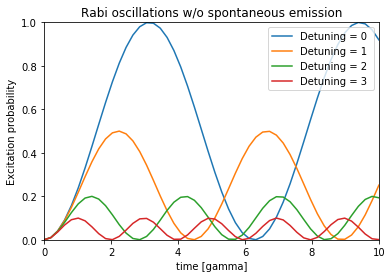

In [3]:
###############################################################################
## Rabi oscillations with no spontaneous emission, for various values
## of detuning from the transition resonance
###############################################################################

def derivs(y0,t,t1,t2,D,O):
# def derivs(t,y0,params):
    """ Returns RHS of optical bloch eqs for current values at time t"""
    rgg,ree,reg = y0
#     O,D,t1,t2 = params # Rabi freq,detuning,lifetime,coherence
    
    # time derivatives of density op elements
    curl = 1j/2*(O*cc(reg)-cc(O)*reg) 
    drgg = ree/t1 - curl 
    dree = -ree/t1 + curl
    dreg = (1j*D-1/(2*t1))*reg+1j*O/2*(rgg-ree) # = cc(drge)
    
    return np.array([drgg,dree,dreg])

# initial conditions - system starts in ground state
rho_ee = 0 + 0j
rho_gg = 1 + 0j
rho_eg = 0 + 0j # no initial mixing; this is actually rho^tilda_ge
y0 = np.array([rho_gg,rho_ee,rho_eg]) # bundle i.c.

# equation parameters
t1 = np.inf # upper state lifetime (1/gamma)
t2 = np.inf # atomic coherence 
D_arr = np.arange(0,4,step=1) # the detuning; run for various values! 
Omega = 1 #1/t1 # treat as real. d*E*exp(-1j*theta) # complex rabi frequency
#params = np.array([Omega,D,t1,t2]) # bundle parameters

# TODO: for param in params: if type(param) = list, iterate over the param
t_exp = 10 # experiment duration
# t = np.arange(t_exp,step=dt)
t = np.linspace(0,t_exp,50)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylim((0,1))
ax.set_xlim((0,t_exp))
ax.set_title('Rabi oscillations w/o spontaneous emission')
ax.set_xlabel('time [gamma]')
ax.set_ylabel('Excitation probability')

comp_time = 0
for D in D_arr: # solve and plot for each detuning value
    soln,ctime = odeintz(derivs, y0, t, args=(t1,t2,D,Omega))
    ax.plot(t,soln[:,1],label="Detuning = %s "%D) # plot rho_ee
    comp_time += ctime
print("computation time = %f [s]" % comp_time)

ax.legend(loc='upper right')
plt.show()

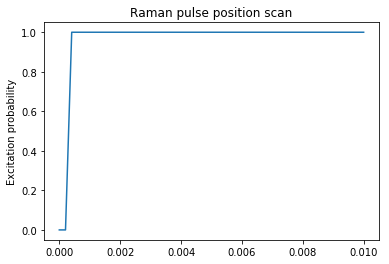

In [61]:
###############################################################################
## Raman pulse for different spatial overlap at atom trap site 
## of detuning from the transition resonance
###############################################################################

## TODO:
# - change eqs to two-photon eqs
# - get power seen by an atom at some fixed x=x0 for as a function of position 
#   of a Gaussian beam with 
#   an intensity given by the known input power and expected beam waist
# - use that power to define a Rabi frequency for a given beam position in x
# - solve the two-photon O.B.E.s for a Rabi freq. at various x values, and
#   store the last point of each soln (how far the state rotated during the 
#   pulse)
# - repeat for off-center sites, which have Rabi freq different detunings 
#   (smaller trap depth, so less A.C. stark shift, less resonant with applied 
#   light)

## physical constants
e = 1.60217662e-19 # [C]
a0 = 5.22e-11 # [m]
hbar = 1.0545718e-34 # [J s]
c = 3e8 # [m]
e0 = 8.85418782e-12 # [m^-3 kg^-1 s^4 A^2]

def Intensity(P,w0,r,A=None,r0=None):
    """ Gaussian beam intensity.
        'P' power
        'A' area
    """
    if r0 is None:
        r0 = 0
    if A is None:
        A = pi*w0**2
    
    return (P/A)*np.exp(-(r-r0)**2/(2*w0**2))

def derivs(y0,t,DD1,DD2,D,O_r):
    """ Returns RHS of optical bloch eqs for current values at time t"""
    c_g,c_r = y0
#     O,D,t1,t2 = params # Rabi freq,detuning,lifetime,coherence
    
    # time derivatives of state amplitudes (Mark's notes, eqs 11.4)
    dcg = -1j*(DD1*c_g+cc(O_r)*c_r)/2
    dcr = 1j*(DD2*c_r-O_r*c_g)/2
    
    return np.array([dcg,dcr])

## experiment parameters and pertinent quantities
P = 2*(3e-6) # [W] beam power per sideband at atoms
w0 = 6e-6 # [m] expected Gaussian beam waist at atoms
D = 2*pi*2*4.5e10
D1 = D # to a good approximation
D2 = D # "

o1DipoleElem = -1.792e-29 # see rb_matrix_elements
o2DipoleElem = -1.792e-29

# Rabi frequencies and the position values to be scanned
r_vals = np.linspace(-10e-6,10e-6,11) # the positions to scan
O_vals = (2/(c*e0*hbar**2))*Intensity(P,w0,r_vals) \
        *o1DipoleElem*o2DipoleElem \
        /(2*D)

## pulse durations
t_exp = 1e-5 # [s], 20 us  ~ pi/2 time we've been using
t = np.linspace(0,t_exp,50)

## initial conditions - system starts in ground state (|F=2,mF=0>)
c_g = 1 + 0j
c_r = 0 + 0j
y0 = np.array([c_g,c_r]) # bundle i.c.

fig = plt.figure()
ax = fig.add_subplot(111)
# ax.set_ylim((0,1))
ax.set_title('Raman pulse position scan')
# ax.set_xlabel('position [um]')
ax.set_ylabel('Excitation probability')

## run the parameter scan
prob_e = np.empty(len(r_vals))
i = 0

# for O_r in O_vals:
#     soln,ctime = odeintz(derivs, y0, t, args=(D1,D2,D,O_r))
#     c_g = soln[:,0][-1]
#     prob_e[i]=1 - abs(c_g)**2 # prob excitation after pulse
#     i+=1
    
# ax.scatter(r_vals/1e-6,prob_e)


## test a single Rabi frequency
O = 324623.79048954 # Two-photon Rabi f
D = 2*pi*2*4.5e10 # [Hz]
O1 = sqrt(2*D*O) # Single-photon Rabi f
O2 = O1
DD1 = D + (2*(O1)**2)/D
DD2 = D - (2*(O2)**2)/D

soln,ctime = odeintz(derivs, y0, t, args=(DD1,DD2,D,O))
prob_e = [1-abs(x)**2 for x in soln[:,0]]
ax.plot(t/1e-3,prob_e)

# ax.legend(loc='upper right')
plt.show()

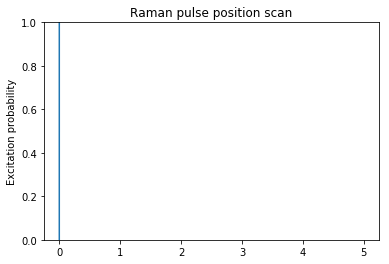

In [61]:
###############################################################################
## Raman pi/2 pulse for different spatial overlap at atom trap site 
## of detuning from the transition resonance
###############################################################################

## TODO:
# - change eqs to two-photon eqs
# - get power seen by an atom at some fixed x=x0 for as a function of position 
#   of a Gaussian beam with 
#   an intensity given by the known input power and expected beam waist
# - use that power to define a Rabi frequency for a given beam position in x
# - solve the two-photon O.B.E.s for a Rabi freq. at various x values, and
#   store the last point of each soln (how far the state rotated during the 
#   pulse)
# - repeat for off-center sites, which have Rabi freq different detunings 
#   (smaller trap depth, so less A.C. stark shift, less resonant with applied 
#   light)

## physical constants
e = 1.60217662e-19 # [C]
a0 = 5.22e-11 # [m]
hbar = 1.0545718e-34 # [J s]
c = 3e8 # [m]
e0 = 8.85418782e-12 # [m^-3 kg^-1 s^4 A^2]

def Intensity(P,w0,r,A=None,r0=None):
    """ Gaussian beam intensity at radius 'r' for
        'P' power
        'w0' beam waist
        'A' area
    """
    if r0 is None:
        r0 = 0
    if A is None:
        A = pi*w0**2
    
    return (P/A)*np.exp(-(r-r0)**2/(2*w0**2))

def derivs(y0,t,d,D,O1,O2):
    """ Returns RHS of optical bloch eqs for current values at time t"""
    c_g,c_r,c_e = y0
    
    # time derivatives of state amplitudes (Mark's notes, eqs 11.3)
    dcg = -1j*(D*c_g-cc(O1)*c_e)/2
    dce = 1j*(d*c_e+O1*c_g+cc(O2)*c_r)/2
    dcr = 1j*(D*c_r + O2*c_e)/2
    
    return np.array([dcg,dcr,dce])

## experiment parameters and pertinent quantities
P = 2*(3e-6) # [W] beam power per sideband at atoms
w0 = 6e-6 # [m] expected Gaussian beam waist at atoms
# D = 2*pi*2*4.5e10 # []
# D1 = D/2 # to a good approximation
# D2 = D/2 # "

o1DipoleElem = -1.792e-29 # see rb_matrix_elements
o2DipoleElem = -1.792e-29

# Rabi frequencies and the position values to be scanned
r_vals = np.linspace(-10e-6,10e-6,11) # the positions to scan
O_vals = (2/(c*e0*hbar**2))*Intensity(P,w0,r_vals) \
        *o1DipoleElem*o2DipoleElem \
        /(2*D)

## initial conditions - system starts in ground state (|F=2,mF=0>)
c_g = 1 + 0j
c_r = 0 + 0j
c_e = 0 + 0j
y0 = np.array([c_g,c_r,c_e]) # bundle i.c.

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylim((0,1))
ax.set_title('Raman pulse position scan')
# ax.set_xlabel('position [um]')
ax.set_ylabel('Excitation probability')

## run the parameter scan
prob_e = np.empty(len(r_vals))
i = 0

## test a single Rabi frequency
O = 0.324 # [MHz] 324623.79048954 # Two-photon Rabi f
d = 0 # D1-D2, D1 = D2
D = 2*2*pi*4.5e4 # [MHz] # D = D1 + D2, D1 = D2 
O1 = sqrt(2*D*O) # Single-photon Rabi f, for O1 = O2
O2 = O1
# DD1 = D + (2*(O1)**2)/D
# DD2 = D - (2*(O2)**2)/D

## pulse duration
t_exp = 5 # [us]  ~ pi/2 time we've been using
# t = np.linspace(0,t_exp,)

# soln,ctime = odeintz(derivs, y0, t, args=(d,D,O1,O2))
# prob_e = [1-abs(x) for x in soln[:,0]] # should be abs(x)**2
# ax.plot(t,prob_e)

## Try with solve_ivp
from scipy.integrate import solve_ivp
# t = np.linspace(0,t_exp,100)
func = lambda y,t: derivs(y0,t,d,D,O1,O2)
soln = solve_ivp(func,[0,t_exp],y0,t_eval=np.linspace(0,t_exp,50),
                method='RK45')
ypts = [abs(y)**2 for y in soln.y[2]]
ax.plot(soln.t,ypts)

# ax.legend(loc='upper right')
plt.show()

In [65]:
np.real(soln.y[0])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])